### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  downward
         z[0] = 0  (top)
         z[-1] = 100  (bottom)

In [47]:
import numpy as np
import matplotlib.pylab as plt
# plt.style.use('ggplot')
import time

In [48]:
%matplotlib inline

In [3]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    return [C,K,theta]

In [4]:
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368;
theta_R = 0.102;
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09
### add second layer parameters

In [5]:
# Store van Genuchten parameters in array
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [6]:
# make mesh variables
dz = 1.; # [cm]
zmin = 0.; # [cm]
zmax = 100.; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

# Define boundary conditions at top and bottom
hinit = np.arange(nz)*-5
htop = hinit[0]

# htop = -30
# hinit = -1000*np.ones(nz)
# hinit[0] = htop

hbottom = hinit[-1]


In [7]:

# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 

In [8]:
# Define time variables
stop_tol = 1e-5  # Stopping tolerance [cm]
tmin = 0. # [s]


# Define a storage container to store the pressure heads and soil moistures
[Ctop,Ktop,thetatop] = vanGenuchten(htop,phi)
[Cbottom,Kbottom,thetabottom] = vanGenuchten(hbottom,phi)
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 


In [32]:
time_elapse = []
mass_balance = []
total_fluxin = []
dts= [10**x for x in range(-1,3)]
stop_tol = 1e-5
for dt in dts:
    
    tmax = 1000.
    t = np.arange(tmin, tmax + dt, dt)  #(tmin:dt:tmax);
    nt = len(t)
    
    H = np.zeros([nz,nt])
    K = np.zeros([nz,nt])
    C = np.zeros([nz,nt])
    H[:,0] = hinit; K[:, 0] = Kinit; C[:, 0] = Cinit

    THETA = np.zeros([nz,nt])
    THETA[:,0] = thetainit
    ktop = np.zeros([ nt])
    kbot = np.zeros([ nt])
    error = np.zeros([nt]) 
    error2 = np.zeros([nt]) 


    ktop[0] =  (K[0, 0] + K[1, 0])/2.  
    kbot[0] =  (K[-1, 0] + K[-2, 0])/2. 

    start_time = time.time()

#   #Define the container for an iteration counter
    iterations = np.zeros([nt-1,1]);

    # # Initialize the Picard iteration solver
    for i in range(1, nt): 
        hnp1m =  H[:,i-1]  
        #Enter the iteration step
        thetan = THETA[:,i-1]   
        #Define a dummy stopping variable
        stop_flag = 0
        # Define an iteration counter
        niter = 0
        while(stop_flag==0): # Get C,K,theta
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi); 
            #  Compute the individual elements of the A matrix for LHS
            Cdiag = np.diag(cnp1m); 
            kbarplus = (1/2.)*MPlus.dot(knp1m);
            Kbarplus = np.diag(kbarplus); 
            kbarminus = (1/2.)*MMinus.dot(knp1m);
            Kbarminus = np.diag(kbarminus); 
            A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - Kbarminus.dot(DeltaMinus)); 
            #  Compute the residual of MPFD (RHS)
            R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
                (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
            # Compute deltam for iteration level m+1

            deltam = np.linalg.pinv(A).dot(R_MPFD)
            # Increment iteration counter and display number of iterations
            niter = niter + 1;
            if max(abs(deltam[1:(nz-1)]))<stop_tol:
                stop_flag = 1
                hnp1mp1 = hnp1m + deltam # Force boundary conditions       
                hnp1mp1[0] = htop;
                if BottomBoundCon==0:
                    hnp1mp1[nz-1] = hbottom;
                elif (BottomBoundCon==1):
                    hnp1mp1[nz-1] = hnp1m[nz-2];
                [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
                thetanp1mp1 = thetanp1m;
                knp1mp1 = knp1m
                cnp1mp1 = cnp1m            
                hnp1m = hnp1mp1; 
            else:
                hnp1mp1 = hnp1m + deltam;
                hnp1m = hnp1mp1; # Force boundary conditions
                hnp1m[0] = htop;
                if BottomBoundCon==0:
                    hnp1m[nz-1] = hbottom;
                elif BottomBoundCon==1:
                    hnp1m[nz-1] = hnp1m[nz-2];
        # Closes while(stop_flag==0) H(:,i) = hnp1mp1;
        THETA[:,i] = thetanp1mp1; 
        H[:,i] = hnp1mp1;
        K[:, i]= knp1mp1;
        C[:, i] = cnp1mp1;
        ktop[i] =  (K[0, i] + K[1, i])/2.  
        kbot[i] =  (K[-1, i] + K[-2, i])/2.   #(knp1mp1[-1] + knp1mp1[-2])/2.  
        error[i] = np.sum(A.dot(deltam))*dt
        error2[i] = dz*np.sum(C[:,i]*deltam[:]) -  kbot[i]*(deltam[-1] - deltam[-2])*dt/dz \
                 + ktop[i]*(deltam[1] - deltam[0])*dt/dz

    iterations[i-1] = niter;
    fluxin =  -  ktop*((H[1] - H[0])/dz + 1.)*dt   # top flux
    fluxout =  kbot*((H[-1] - H[-2])/dz + 1. )*dt # bottom flux
    newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 
    time_elapse.append(time.time() - start_time)
    mass_balance.append(np.cumsum(fluxin[1:] - newmass + fluxout[1:] - error[1:] )[-1])
    total_fluxin.append(np.cumsum(fluxin[1:] )[-1])

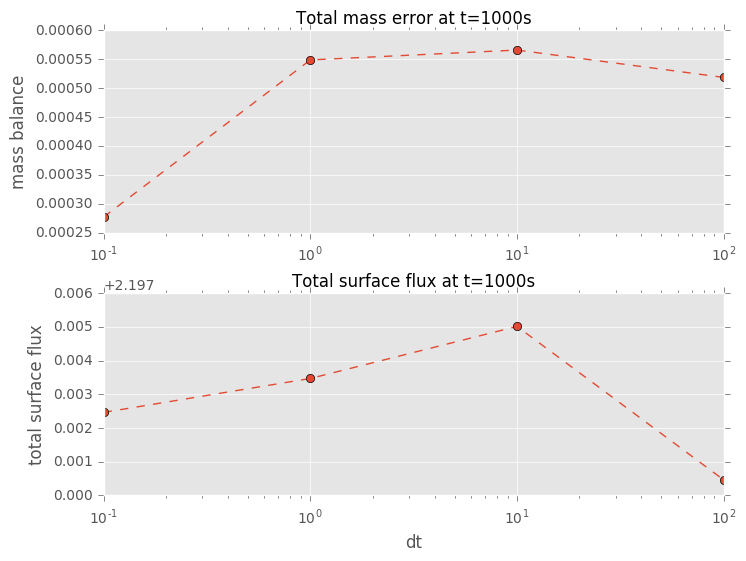

In [46]:
fig = plt.figure(figsize= (8,6))
fig.subplots_adjust(hspace = .3)
plt.subplot(211)
plt.semilogx(dts[:], -np.array(mass_balance[:]), 'o--')
plt.ylabel("mass balance")
plt.title('Total mass error at t=1000s', fontsize = 12)

plt.subplot(212)
plt.semilogx(dts[:], np.array(total_fluxin[:]), 'o--')
plt.xlabel("dt")
plt.ylabel("total surface flux")
plt.title('Total surface flux at t=1000s', fontsize = 12)



In [41]:
# plt.loglog(dts, time_elapse, 'o--')

In [37]:
total_fluxin[:]

[2.1994628514372851,
 2.2004696469688287,
 2.2020145329026684,
 2.1974596424823103]

In [12]:
# plt.imshow(THETA[:, 1:2000:10])

In [13]:
# plt.plot(Kp5)
# kbot - Kn5

In [14]:
fluxin =  -  ktop*((H[1] - H[0])/dz + 1.)*dt   # top flux

In [15]:
fluxout =  kbot*((H[-1] - H[-2])/dz + 1. )*dt # bottom flux
# fluxout =  kbot*((H[-1] - H[-2])/dz )*dt # bottom flux


In [16]:
newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 

In [17]:
np.cumsum(fluxin[2:] - newmass[:-1] + fluxout[2:] - error[2:] )

array([-0.34717704, -0.44336698, -0.49110792, -0.52053051, -0.54083351,
       -0.55585297, -0.56750468, -0.57686035, -0.58457099])

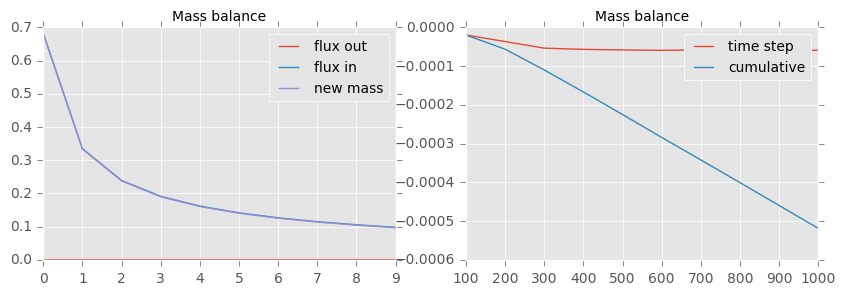

In [18]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:] - error[1:],  label = 'time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:] - error[1:] ), label =  'cumulative')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:] - error2[1:]), '--', label =  'unclosed')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:]), label =  'cumulative')
plt.legend(fontsize = 10)
# (fluxin[1:] - newmass  + fluxout[1:] +error[1:])

In [19]:
plt.figure(5);
plt.plot(t[1:nt],iterations,'o-');
plt.xlabel('Time [s]');
plt.ylabel('Number of iterations');

NameError: name 'iterations' is not defined

In [ ]:
#  plot mass balance terms
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:],  label = 'each time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass+ fluxout[1:]), label =  'cumulative')
plt.legend(fontsize = 10)

In [ ]:
for dt in dts:    
    tmax = 1000.
#   tmax = dt*(nt - 1.) # [s]
    t = np.arange(tmin, tmax + dt, dt)  #(tmin:dt:tmax);
    print t[-1]